This notebook runs within gammapy-1.1. (Only to have scipy and minuit imported, other gammapy functions are not used)

In [1]:
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
from  iminuit import Minuit


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

### Energy Reconstruction
The energy reconstruction describes the probability to reconstruct the true energy value.
It is a Gaussian distributed around e_true with the energy resolution as the variance

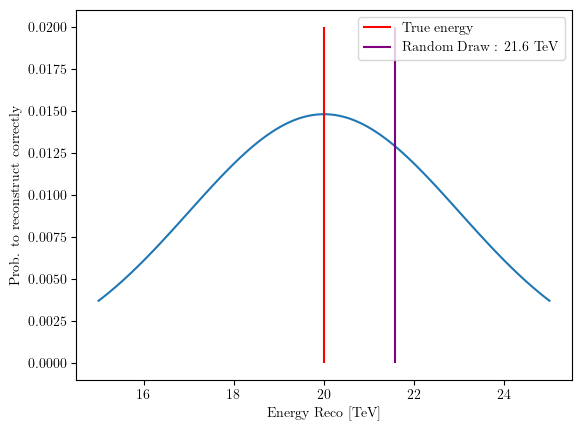

In [3]:
def energy_reco(e_reco, e_true, deltae):
    return  np.exp(-0.5 * ((e_reco - e_true) / deltae) ** 2)

e_true = 20
deltae = 3.
delta_comp =5
e_reco = np.linspace(e_true- delta_comp, e_true+delta_comp, 100)
energy_distribution = energy_reco(e_reco, e_true, deltae)
energy_distribution /= np.sum(energy_distribution)
plt.plot(e_reco, energy_distribution)
plt.vlines(e_true, 0., 0.02, label = "True energy", color = 'red')
plt.xlabel("Energy Reco [TeV]")
plt.ylabel("Prob. to reconstruct correctly ")

# random draw from this distribution:
energyreco = np.random.choice(e_reco, size=1, p= energy_distribution)[0]
plt.vlines(energyreco, 0., 0.02, label = f"Random Draw : {energyreco:.3} TeV", color = 'purple')
plt.legend()


### Count distribution

The counts are Poisson distributed. lambda is set to 40 TeV. And 1e3 samples are drawn. 

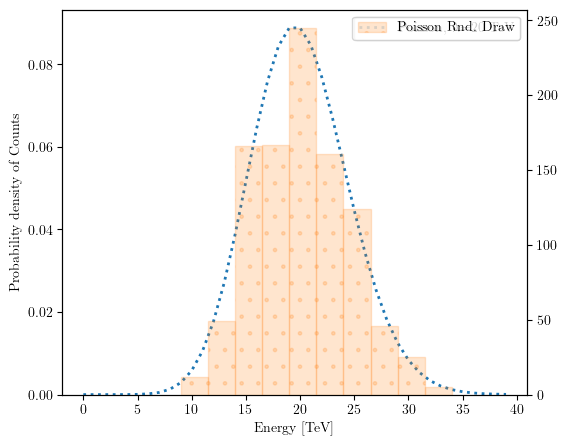

In [4]:
xmax = 40
mu_p = 20

#fig,ax = plt.subplots(1,1, figsize=(4, 3))
fig,ax = plt.subplots(1,1, figsize=(6, 5))

k_values = np.array(list(range(0, xmax)))
count_distr = [poisson.pmf(k, mu=mu_p) for k in k_values]
count_distr /= np.sum(count_distr)
ax.plot(k_values, count_distr , label = "Poisson, $\lambda$=20 TeV" , linestyle = ':',
        linewidth = 2,
       color = 'tab:blue')
plt.xlabel('Energy [TeV]')
plt.ylabel('Probability density of Counts')

ax2 = ax.twinx()
size = int(1e3)
samples_p = np.random.choice(k_values, size=size, p=count_distr)
c, bins, _ = ax2.hist(samples_p, density= False, label = "Poisson Rnd. Draw", alpha = 0.2, hatch = '.', 
                      edgecolor = 'tab:orange', color = 'tab:orange')
ax2.set_xlabel('Counts')

ax.set_ylim(0, ax.get_ylim()[1])
ax.legend()
ax2.legend()

### Apply the energy dispersion
For each of the drawn sample true energies the energy reconstruction is computed. Afterwards a reconstructed energy is drawn from this reconstruction probability. All reco energies are saved in ``samples``. 

17
13.11111111111111


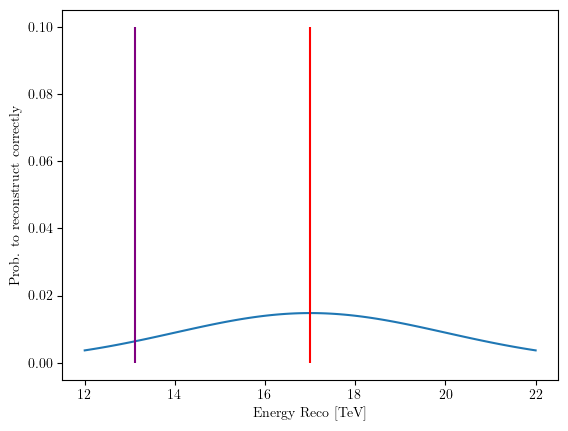

In [5]:
samples = []
for i, s in enumerate(samples_p):
    reco_values = np.linspace(s-delta_comp, s+delta_comp,100)
    energy_distribution = energy_reco(reco_values, s, deltae)
    energy_distribution /= np.sum(energy_distribution)
    rnd = np.random.choice(reco_values, size=1, p= energy_distribution)[0]
    if i<1:
        print(s)
        print(rnd)
        plt.figure()
        plt.plot(reco_values, energy_distribution)
        plt.vlines(s, 0., 0.1, label = "True energy", color = 'red')
        plt.xlabel("Energy Reco [TeV]")
        plt.ylabel("Prob. to reconstruct correctly ")
        plt.vlines(rnd, 0., 0.1, label = f"Random Draw : {rnd:.3} TeV", color = 'purple')
        plt.show()
        plt.close()
    samples.append(rnd)

In [6]:
def gaussian_2(x, mu, sigma, norm = 1):
    return norm * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# approximate the poisson distribution with a Gaussian, this is only to have a nicer plot. 
p_to_G = gaussian_2(k_values, mu = mu_p, sigma = np.sqrt(mu_p), norm = 1)
p_to_G /= np.sum(p_to_G)
# approximate the poisson distribution wiht systematic with a Gaussian with sigma = sqrt(lamda  + delta E**2)
# this is also just for plotting purposes
sys = gaussian_2(k_values, mu = mu_p, sigma = np.sqrt(mu_p + deltae**2), norm = 1)
sys /= np.sum(sys)

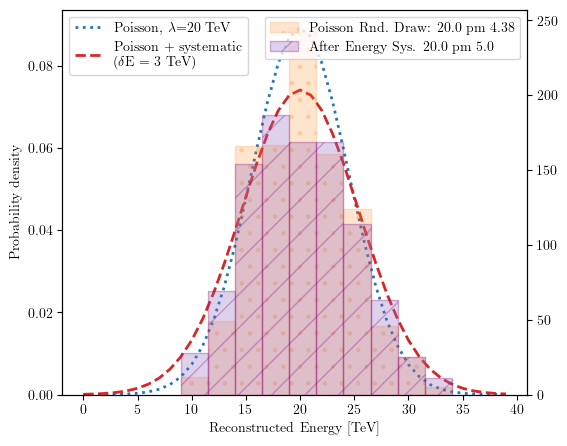

In [7]:
fig,ax = plt.subplots(1,1, figsize=(6, 5))
#ax.plot(k_values, count_distr , label = "Poisson" , linestyle = '-.')
plt.xlabel('Energy [TeV]')
plt.ylabel('Probability density of Counts')

ax.plot(k_values, p_to_G , label = "Poisson, $\lambda$=20 TeV" , linestyle = ':',
        linewidth = 2,
       color = 'tab:blue')

ax.plot(k_values, sys , label = "Poisson + systematic \n($\delta$E = 3 TeV)" , linestyle = '--',
        linewidth = 2,
       color = 'tab:red')
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc = 'upper left')
plt.xlabel('Reconstructed Energy [TeV]')
plt.ylabel('Probability density')

ax2 = ax.twinx()
size = int(1e3)
c, bins, _ = ax2.hist(samples_p, density= False, 
                      label = f"Poisson Rnd. Draw: {np.mean(samples_p):.3} pm {np.std(samples_p):.3}",
                      alpha = 0.2,
                      hatch = '.', edgecolor = 'tab:orange', color = 'tab:orange')

c, bins, _ = ax2.hist(samples, bins = bins, density= False,
                      label =f"After Energy Sys. {np.mean(samples):.3} pm {np.std(samples):.3}", alpha = 0.3, hatch = '/', 
                      edgecolor = 'purple',
                     color = 'tab:purple')




ax2.legend()

## Maximum Liklelihood Estimator
To the ``samples`` distribution a Gaussian is fitted to find the center of the distribution ``E_c``. 

In [8]:
def gaussian(x, mu, sigma, norm = 1):
    return norm / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


In [9]:
def Likelihood_cost( mu, sigma, norm):
    mu = gaussian(bin_center, mu, sigma, norm )
    L = np.sum(mu - c * np.log(mu))
    return L

In [10]:
#Fitting:
mu_guess = 20
sigma_guess = 8
norm_guess = 3e3
bin_center = (bins[1:] + bins[:-1] )/2



minuit = Minuit(Likelihood_cost, mu = mu_guess, sigma = sigma_guess, norm = norm_guess)
m = minuit.migrad()
print(m)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3787                      │              Nfcn = 68               │
│ EDM = 9.6e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

In [11]:
# Print the estimated parameters and their uncertainties
print(f"The estimated parameters are: {m.values}")
print(f"The parameter uncertainties are: {m.errors}")

The estimated parameters are: <ValueView mu=19.891551867667552 sigma=5.175193269189726 norm=2522.04184509336>
The parameter uncertainties are: <ErrorView mu=0.25092953602773593 sigma=0.21055487735625725 norm=114.20206385990542>


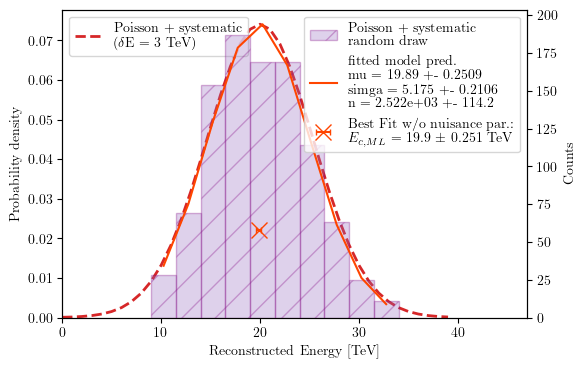

3.010475980978937


In [12]:


fig,ax = plt.subplots(1,1, figsize=(6, 4))
# prob. distribtutions:
ax.plot(k_values, sys , label = "Poisson + systematic \n($\delta$E = 3 TeV)" , linestyle = '--',
        linewidth = 2,
       color = 'tab:red')

ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Reconstructed Energy [TeV]')
ax.set_ylabel('Probability density')
ax.legend(loc = 'upper left')
ax.set_xlim(0,47)

# sample distributions:
ax2 = ax.twinx()
c, bins, _ = ax2.hist(samples, bins = bins, density= False,
                      label = "Poisson + systematic \n random draw", alpha = 0.3, hatch = '/', 
                      edgecolor = 'purple',
                     color = 'tab:purple')

# best-fit results:
label = "Best Fit w/o nuisance par.: \n $E_{c,ML}$ ="
ax2.errorbar(x = m.values[0], y = ax2.get_ylim()[1]/2-40, xerr =m.errors[0], fmt = 'x'  ,
               markersize= 11,capsize = 2,
             label =label +  f'  { m.values[0]:.3} $\pm$ {m.errors[0]:.3} TeV',
            color = 'orangered')
model_pred_fitted =  gaussian(bin_center, m.values[0], m.values[1], m.values[2])
ax2.plot(bin_center, model_pred_fitted, color = 'orangered',
        label = f"fitted model pred. \n mu =  { m.values[0]:.4} +- {m.errors[0]:.4} \n simga = {m.values[1]:.4} +- {m.errors[1]:.4} \nn = { m.values[2]:.4} +- {m.errors[2]:.4}")



ax2.set_ylabel("Counts")
ax2.legend(loc = 'upper right')
plt.show()
print(np.sqrt(m.errors[0]**2 + 3**2))


## Maximum A Posteriori Estimator

In [13]:
def prior(x):
    p =  (x-mu)**2 / sigma_sys**2
    return p
mu = 0
sigma_sys = deltae

In [14]:
def gaussian_model_nui(x, mu, sigma, norm, nui):
    return norm / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu -nui) / sigma) ** 2)


In [16]:
def posterior( mu, sigma, norm, nui):
    mu = gaussian_model_nui(bin_center, mu, sigma, norm, nui )
    L = np.sum(mu - c * np.log(mu))
    P = prior(nui)
    return L + P

In [17]:
mu_guess_2 = 20
sigma_guess_2 = 8
norm_guess_2 = 3000
nui_gues_2 = 0.0



minuit_prior = Minuit(posterior, mu = mu_guess_2, sigma = sigma_guess_2, norm =norm_guess_2, nui = nui_gues_2)
m_prior = minuit_prior.migrad()
print(m_prior)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3787                      │              Nfcn = 110              │
│ EDM = 7.02e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

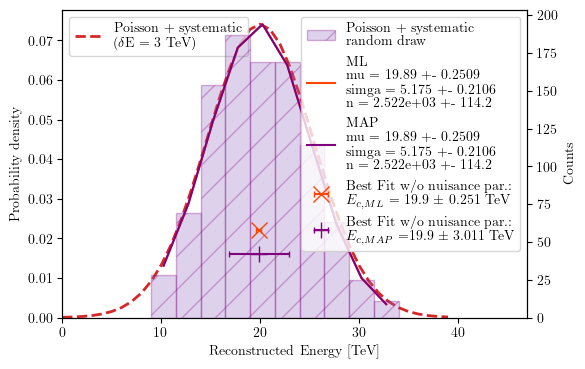

3.010475980978937


In [18]:


fig,ax = plt.subplots(1,1, figsize=(6, 4))
# prob. distribtutions:
ax.plot(k_values, sys , label = "Poisson + systematic \n($\delta$E = 3 TeV)" , linestyle = '--',
        linewidth = 2,
       color = 'tab:red')

ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Reconstructed Energy [TeV]')
ax.set_ylabel('Probability density')
ax.legend(loc = 'upper left')
ax.set_xlim(0,47)

# sample distributions:
ax2 = ax.twinx()
c, bins, _ = ax2.hist(samples, bins = bins, density= False,
                      label = "Poisson + systematic \n random draw", alpha = 0.3, hatch = '/', 
                      edgecolor = 'purple',
                     color = 'tab:purple')

# best-fit results:
label = "Best Fit w/o nuisance par.: \n $E_{c,ML}$ ="
ax2.errorbar(x = m.values[0], y = ax2.get_ylim()[1]/2-40, xerr =m.errors[0], fmt = 'x'  ,
               markersize= 11,capsize = 2,
             label =label +  f'  { m.values[0]:.3} $\pm$ {m.errors[0]:.3} TeV',
            color = 'orangered')
model_pred_fitted =  gaussian(bin_center, m.values[0], m.values[1], m.values[2])
ax2.plot(bin_center, model_pred_fitted, color = 'orangered',
        label = f"ML\n mu =  { m.values[0]:.4} +- {m.errors[0]:.4} \n simga = {m.values[1]:.4} +- {m.errors[1]:.4} \nn = { m.values[2]:.4} +- {m.errors[2]:.4}")


label = "Best Fit w/o nuisance par.: \n $E_{c,MAP}$ ="
ax2.errorbar(x = m_prior.values[0], y = ax2.get_ylim()[1]/2-60, xerr =m_prior.errors[0], fmt = '+' ,
             markersize= 11,capsize = 2,
           label= label +  f"{ m_prior.values[0]:.3} $\pm$ {m_prior.errors[0]:.4} TeV ", 
             color = 'Purple')
model_pred_fitted =  gaussian(bin_center, m_prior.values[0], m_prior.values[1], m_prior.values[2])
ax2.plot(bin_center, model_pred_fitted, color = 'Purple',
        label = f"MAP \n mu =  { m.values[0]:.4} +- {m.errors[0]:.4} \n simga = {m.values[1]:.4} +- {m.errors[1]:.4} \nn = { m.values[2]:.4} +- {m.errors[2]:.4}")


ax2.set_ylabel("Counts")
ax2.legend(loc = 'upper right')
plt.show()
print(np.sqrt(m.errors[0]**2 + 3**2))


## Final Plot

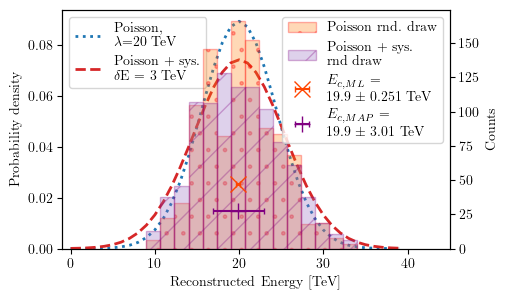

3.010475980978937


In [47]:

fig,ax = plt.subplots(1,1, figsize=(5, 3.1))
# prob. distribtutions:
ax.plot(k_values, p_to_G , label = "Poisson, \n$\lambda$=20 TeV" , linestyle = ':',
        linewidth = 2,
       color = 'tab:blue')

ax.plot(k_values, sys , label = "Poisson + sys. \n$\delta$E = 3 TeV" , linestyle = '--',
        linewidth = 2,
       color = 'tab:red')

ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Reconstructed Energy [TeV]')
ax.set_ylabel('Probability density')
ax.legend(loc = 'upper left')
ax.set_xlim(-1,45)

# sample distributions:
ax2 = ax.twinx()
c, bins, _ = ax2.hist(samples_p, density= False, bins =15,
                      label = "Poisson rnd. draw", alpha = 0.3, hatch = '.', edgecolor = 'red',
                     color = 'tab:orange')
c, bins, _ = ax2.hist(samples, bins = bins, density= False,
                      label = "Poisson + sys. \n rnd draw", alpha = 0.3, hatch = '/', 
                      edgecolor = 'purple',
                     color = 'tab:purple')

# best-fit results:
label = "Best Fit w/o nui. par.: \n $E_{c,ML}$ ="
label = " $E_{c,ML}$ ="

ax2.errorbar(x = m.values[0], y = ax2.get_ylim()[1]/2-40, xerr =m.errors[0], fmt = 'x'  ,
               markersize= 11,capsize = 2,
             label =label +  f'\n  { m.values[0]:.3} $\pm$ {m.errors[0]:.3} TeV',
            color = 'orangered')
label = "Best Fit w/o nui. par.: \n $E_{c,MAP}$ ="
label = "$E_{c,MAP}$ ="

ax2.errorbar(x = m_prior.values[0], y = ax2.get_ylim()[1]/2-60, xerr =m_prior.errors[0], fmt = '+' ,
             markersize= 11,capsize = 2,
           label= label +  f"\n{ m_prior.values[0]:.3} $\pm$ {m_prior.errors[0]:.3} TeV ", 
             color = 'Purple')

ax2.set_ylabel("Counts")
ax2.legend(loc = 'upper right')
plt.show()
print(np.sqrt(m.errors[0]**2 + 3**2))

fig.savefig("prob_best_fit.png", bbox_inches='tight')
fig.savefig("prob_best_fit.svg", bbox_inches='tight')
fig.savefig("prob_best_fit.pdf", bbox_inches='tight')

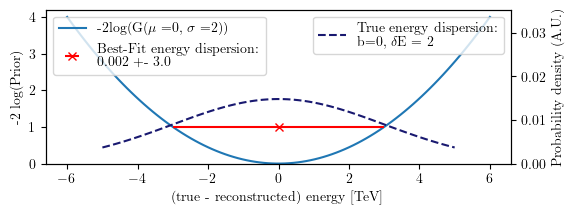

In [46]:
fig,ax = plt.subplots(1,1, figsize = (6,2))
nui_values = np.linspace(-sigma_sys*2, sigma_sys*2, 100)

ax.plot(nui_values, prior(nui_values), label = "-2log(G($\mu$ =0, $\sigma$ =2))")
ax.set_xlabel("Energy resolution nuisance parameter Value [TeV]")
ax.set_xlabel("(true - reconstructed) energy [TeV]")

ax.set_ylabel("-2 log(Prior)")
e_true = 0.
e_reco = np.linspace(e_true- delta_comp, e_true+delta_comp, 100)
energy_distribution = energy_reco(e_reco, e_true, deltae)
energy_distribution /=np.sum(energy_distribution)
ax.set_ylim(0, ax.get_ylim()[1])

#energy_distribution /= np.sum(energy_distribution)
ax2 =plt.twinx()

ax2.plot(e_reco, energy_distribution, label = "True energy dispersion:\n b=0, $\delta$E = 2", 
         color = 'midnightblue', linestyle = '--')
ax2.set_ylim(0, ax2.get_ylim()[1]*2.3)
ax2.set_ylabel("Probability density (A.U.)")
ax2.legend()
ax.errorbar(x = m_prior.values[3], y = 1, xerr =m_prior.errors[3], fmt = 'x' ,
           label= f"Best-Fit energy dispersion:\n { m_prior.values[3]:.1} +- {m_prior.errors[3]:.2} ", color = 'red')
ax.legend(loc = 'upper left')

fig.savefig("prior.png")
fig.savefig("prior.pdf")